In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import requests
from bs4 import BeautifulSoup
import csv

In [88]:
def scrape_stock_info(stock_symbol):
    url = f"https://finance.yahoo.com/quote/{stock_symbol}"

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        price_element = soup.find('fin-streamer', class_='livePrice svelte-mgkamr')
        price = price_element.text.strip() if price_element else None

        name_element = soup.find('h1', class_ ="svelte-3a2v0c")
        name = name_element.text.strip() if name_element else None

        return {'Stock Name': name, 'Stock Price': price}
    else:
        print(f"Error: Failed to retrieve webpage for stock symbol {stock_symbol}")
        return None

In [89]:
def save_to_csv(data, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data.keys())
        writer.writeheader()
        writer.writerow(data)

In [90]:
symbol = str(input("Enter the stock symbol(): "))
symbols = (symbol.upper()).split(" ")
for s in symbols:
    stock_data = scrape_stock_info(s)
    if stock_data:
        save_to_csv(stock_data, f"{s}_data.csv")
        print(f"Stock information for {s} has been saved to {s}_data.csv")
    else:
        print(f"There is no stock information for {s}")

Enter the stock symbol(): TSLA
Stock information for TSLA has been saved to TSLA_data.csv


## Predict

In [5]:
symbol = str(input("Enter stock symbol"))
period1 = int(time.mktime(datetime.datetime(1971, 2, 5, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime.today().timetuple()))
interval = '1d'

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

Enter stock symbolTSLA


In [59]:
df = pd.read_csv(query_string)
# print(df)
df.to_csv(f'{symbol}.csv')

In [60]:
df = pd.read_csv(f"{symbol}.csv")
del df["Unnamed: 0"]
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3502,2024-05-29,174.190002,178.149994,173.929993,176.190002,176.190002,54782600
3503,2024-05-30,178.580002,182.669998,175.380005,178.789993,178.789993,77784800
3504,2024-05-31,178.500000,180.320007,173.820007,178.080002,178.080002,67314600
3505,2024-06-03,178.130005,182.639999,174.490005,176.289993,176.289993,68568900


<Axes: xlabel='Date'>

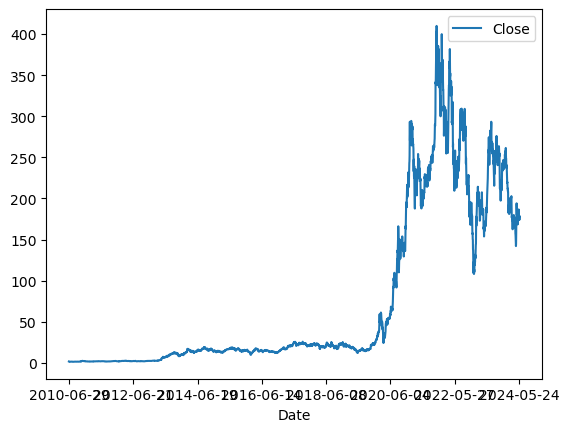

In [61]:
df.plot.line(x = "Date", y = "Close")

In [62]:
del df["Adj Close"]
df["Target-3"] = df["Close"].shift(3)
df["Target-2"] = df["Close"].shift(2)
df["Target-1"] = df["Close"].shift(1)
df["Target"] = ((df["Close"] - df["Open"]) > 0).astype(int)
df.set_index('Date', inplace = True)
df = df.dropna()

In [63]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = df.rolling(horizon).mean()

  ratio = f"Close_Ratio_{horizon}"
  df[ratio] = df["Close"].shift(1) / rolling_averages["Close"]

  trend = f"Trend_Ratio"
  df[trend] = df["Target"].shift(1).rolling(horizon).sum()

  new_predictors += [ratio, trend]

C:\Users\owen\AppData\Local\Temp\ipykernel_4976\1596686111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ratio] = df["Close"].shift(1) / rolling_averages["Close"]
C:\Users\owen\AppData\Local\Temp\ipykernel_4976\1596686111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[trend] = df["Target"].shift(1).rolling(horizon).sum()
C:\Users\owen\AppData\Local\Temp\ipykernel_4976\1596686111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [64]:
df = df.dropna()
df

,Open,High,Low,Close,Volume,Target-3,Target-2,Target-1,Target,Close_Ratio_2,Trend_Ratio,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000
Date,,,,,,,,,,,,,,,
2014-06-24,15.931333,16.125334,15.442000,15.500000,121138500,15.186000,15.306000,15.814667,0,1.010049,480.0,1.027620,1.144436,1.347767,3.473936
2014-06-25,15.536667,15.836667,15.349333,15.792667,87024000,15.306000,15.814667,15.500000,1,0.990647,480.0,0.998720,1.119106,1.317130,3.393842
2014-06-26,15.811333,16.026667,15.614000,15.706667,76821000,15.814667,15.500000,15.792667,0,1.002730,481.0,1.010795,1.138535,1.338111,3.446865
2014-06-27,15.646000,16.000000,15.633333,15.937333,84525000,15.500000,15.792667,15.706667,1,0.992711,481.0,0.997232,1.131540,1.327170,3.417076
2014-06-30,15.970000,16.299334,15.933333,16.004000,72429000,15.792667,15.706667,15.937333,1,0.997913,481.0,1.009450,1.146812,1.342961,3.456098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29,174.190002,178.149994,173.929993,176.190002,54782600,173.740005,179.240005,176.750000,1,1.001587,502.0,0.997427,1.027228,0.797138,0.787068
2024-05-30,178.580002,182.669998,175.380005,178.789993,77784800,179.240005,176.750000,176.190002,1,0.992676,502.0,0.995750,1.024167,0.795024,0.784169
2024-05-31,178.500000,180.320007,173.820007,178.080002,67314600,176.750000,176.190002,178.789993,0,1.001989,502.0,1.005511,1.039125,0.807279,0.795352


In [65]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1] # Predict_proba returns the probability of it being a 1 or 0
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index = test.index, name = "Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [66]:
def backtesting(data, model, predictors, start = 1250, step = 250):
  all_preds = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    all = predict(train, test, predictors, model)
    all_preds.append(all)

  return pd.concat(all_preds)

In [67]:
RFC_model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [68]:
predictions = backtesting(df, RFC_model, new_predictors)

In [69]:
predictions["Predictions"].value_counts()

Predictions
0.0    787
1.0    467
Name: count, dtype: int64

In [70]:
predictions

,Target,Predictions
Date,,
2019-06-12,0,0.0
2019-06-13,1,1.0
2019-06-14,1,1.0
2019-06-17,1,1.0
2019-06-18,0,0.0
...,...,...
2024-05-29,1,0.0
2024-05-30,1,1.0
2024-05-31,0,0.0


In [71]:
print(classification_report(predictions["Target"], predictions["Predictions"]))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       615
           1       0.85      0.62      0.72       639

    accuracy                           0.75      1254
   macro avg       0.77      0.75      0.75      1254
weighted avg       0.77      0.75      0.75      1254



In [74]:
tomorrow_data = df.iloc[[-1]]
tomorrow_prediction = RFC_model.predict(tomorrow_data[new_predictors])
if tomorrow_prediction == 1:
    print("Tomorrow's price is predicted to go up.")f
else:
    print("Tomorrow's price is predicted to go down.")

Tomorrow's price is predicted to go down.
